# Configs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [2]:
from utils.prepare_data import getMonitoredPatients

patients = getMonitoredPatients()

In [3]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [4]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# LSTM

### Seperate static and dynamic

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMModel(nn.Module):
    def __init__(self, inSize):
        self.inSize = inSize
        
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size=inSize, hidden_size=64, batch_first=True, dropout=0.5)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        ## dropout
        x = x[:, -1, :]
        x = F.dropout(x, p=0.5)
        x = self.fc1(x)
        
        return x



In [6]:
def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    epochs=20,
    earlyStopping=5,
):
    model.to(device)

    # early stopping
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(epochs):
        model.train()
        trainLoss = 0

        for batchX, batchY in trainLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            loss = criterion(outputs, batchY)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trainLoss += loss.item() * batchX.size(0)

        trainLoss /= len(trainLoader.dataset)
        trainLosses.append(trainLoss)

        # validation
        model.eval()
        valLoss = 0

        with torch.no_grad():
            for batchX, batchY in valLoader:
                batchX, batchY = batchX.to(device), batchY.to(device)

                outputs = model(batchX)
                loss = criterion(outputs, batchY)

                valLoss += loss.item() * batchX.size(0)

        valLoss /= len(valLoader.dataset)
        valLosses.append(valLoss)

        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = model.state_dict()
            patience = 0
        else:
            patience += 1

        print(
            f"Epoch {epoch+1}/{epochs} Train Loss: {trainLoss:.4f} Val Loss: {valLoss:.4f}"
        )

        if patience > earlyStopping:
            break

    model.load_state_dict(bestModelState)
    return model, trainLosses, valLosses


def predTest(model, device, testLoader):
    model.eval()

    predProbas = []
    actuals = []

    with torch.no_grad():
        for batchX, batchY in testLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            probas = torch.sigmoid(outputs)
            predProbas.extend(probas.cpu().numpy())
            actuals.extend(batchY.cpu().numpy())

    return predProbas, actuals

In [8]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )

        model = LSTMModel(inSize=npTrainX.shape[2])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        _, trainLosses, valLosses = train(
            model, device, trainLoader, valLoader, criterion, optimizer, epochs=20
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = predTest(model, device, testLoader)
        probas.append(predProbas)

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6376 Val Loss: 0.6317
Epoch 2/20 Train Loss: 0.5685 Val Loss: 0.5794
Epoch 3/20 Train Loss: 0.5132 Val Loss: 0.5626
Epoch 4/20 Train Loss: 0.4878 Val Loss: 0.5643
Epoch 5/20 Train Loss: 0.4783 Val Loss: 0.5613
Epoch 6/20 Train Loss: 0.4629 Val Loss: 0.5791
Epoch 7/20 Train Loss: 0.4513 Val Loss: 0.5731
Epoch 8/20 Train Loss: 0.4386 Val Loss: 0.5562
Epoch 9/20 Train Loss: 0.4303 Val Loss: 0.5642
Epoch 10/20 Train Loss: 0.4198 Val Loss: 0.5728
Epoch 11/20 Train Loss: 0.4030 Val Loss: 0.5488
Epoch 12/20 Train Loss: 0.3903 Val Loss: 0.5760
Epoch 13/20 Train Loss: 0.3597 Val Loss: 0.5670
Epoch 14/20 Train Loss: 0.3357 Val Loss: 0.5886
Epoch 15/20 Train Loss: 0.3116 Val Loss: 0.6075
Epoch 16/20 Train Loss: 0.2780 Val Loss: 0.6603
Epoch 17/20 Train Loss: 0.2637 Val Loss: 0.6732


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6549 Val Loss: 0.6222
Epoch 2/20 Train Loss: 0.5812 Val Loss: 0.5600
Epoch 3/20 Train Loss: 0.5265 Val Loss: 0.5220
Epoch 4/20 Train Loss: 0.5051 Val Loss: 0.5083
Epoch 5/20 Train Loss: 0.4820 Val Loss: 0.4948
Epoch 6/20 Train Loss: 0.4733 Val Loss: 0.5208
Epoch 7/20 Train Loss: 0.4568 Val Loss: 0.5086
Epoch 8/20 Train Loss: 0.4450 Val Loss: 0.5157
Epoch 9/20 Train Loss: 0.4316 Val Loss: 0.5181
Epoch 10/20 Train Loss: 0.4117 Val Loss: 0.5225
Epoch 11/20 Train Loss: 0.3985 Val Loss: 0.5455


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6669 Val Loss: 0.6218
Epoch 2/20 Train Loss: 0.5847 Val Loss: 0.5468
Epoch 3/20 Train Loss: 0.5299 Val Loss: 0.4935
Epoch 4/20 Train Loss: 0.5096 Val Loss: 0.4786
Epoch 5/20 Train Loss: 0.4894 Val Loss: 0.4721
Epoch 6/20 Train Loss: 0.4773 Val Loss: 0.4612
Epoch 7/20 Train Loss: 0.4782 Val Loss: 0.4537
Epoch 8/20 Train Loss: 0.4645 Val Loss: 0.4880
Epoch 9/20 Train Loss: 0.4481 Val Loss: 0.4638
Epoch 10/20 Train Loss: 0.4390 Val Loss: 0.4599
Epoch 11/20 Train Loss: 0.4288 Val Loss: 0.4686
Epoch 12/20 Train Loss: 0.4175 Val Loss: 0.4488
Epoch 13/20 Train Loss: 0.3926 Val Loss: 0.4654
Epoch 14/20 Train Loss: 0.3837 Val Loss: 0.4448
Epoch 15/20 Train Loss: 0.3527 Val Loss: 0.4506
Epoch 16/20 Train Loss: 0.3397 Val Loss: 0.4452
Epoch 17/20 Train Loss: 0.3089 Val Loss: 0.4347
Epoch 18/20 Train Loss: 0.2914 Val Loss: 0.4351
Epoch 19/20 Train Loss: 0.2874 Val Loss: 0.4353
Epoch 20/20 Train Loss: 0.2596 Val Loss: 0.4256


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6441 Val Loss: 0.6117
Epoch 2/20 Train Loss: 0.5495 Val Loss: 0.5442
Epoch 3/20 Train Loss: 0.5084 Val Loss: 0.5230
Epoch 4/20 Train Loss: 0.4927 Val Loss: 0.5211
Epoch 5/20 Train Loss: 0.4785 Val Loss: 0.5227
Epoch 6/20 Train Loss: 0.4666 Val Loss: 0.5291
Epoch 7/20 Train Loss: 0.4510 Val Loss: 0.5074
Epoch 8/20 Train Loss: 0.4417 Val Loss: 0.5386
Epoch 9/20 Train Loss: 0.4317 Val Loss: 0.5387
Epoch 10/20 Train Loss: 0.4008 Val Loss: 0.5345
Epoch 11/20 Train Loss: 0.3898 Val Loss: 0.5391
Epoch 12/20 Train Loss: 0.3697 Val Loss: 0.5498
Epoch 13/20 Train Loss: 0.3353 Val Loss: 0.5662


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6559 Val Loss: 0.6142
Epoch 2/20 Train Loss: 0.5720 Val Loss: 0.5415
Epoch 3/20 Train Loss: 0.5282 Val Loss: 0.5199
Epoch 4/20 Train Loss: 0.5074 Val Loss: 0.4990
Epoch 5/20 Train Loss: 0.4958 Val Loss: 0.4929
Epoch 6/20 Train Loss: 0.4725 Val Loss: 0.5036
Epoch 7/20 Train Loss: 0.4581 Val Loss: 0.5166
Epoch 8/20 Train Loss: 0.4384 Val Loss: 0.5107
Epoch 9/20 Train Loss: 0.4261 Val Loss: 0.5091
Epoch 10/20 Train Loss: 0.4069 Val Loss: 0.5346
Epoch 11/20 Train Loss: 0.3832 Val Loss: 0.5281


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6401 Val Loss: 0.6392
Epoch 2/20 Train Loss: 0.5580 Val Loss: 0.5951
Epoch 3/20 Train Loss: 0.5057 Val Loss: 0.5937
Epoch 4/20 Train Loss: 0.4746 Val Loss: 0.5900
Epoch 5/20 Train Loss: 0.4571 Val Loss: 0.5816
Epoch 6/20 Train Loss: 0.4452 Val Loss: 0.5806
Epoch 7/20 Train Loss: 0.4327 Val Loss: 0.5863
Epoch 8/20 Train Loss: 0.4249 Val Loss: 0.5877
Epoch 9/20 Train Loss: 0.4063 Val Loss: 0.5876
Epoch 10/20 Train Loss: 0.3837 Val Loss: 0.6000
Epoch 11/20 Train Loss: 0.3691 Val Loss: 0.6240
Epoch 12/20 Train Loss: 0.3412 Val Loss: 0.6272


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6531 Val Loss: 0.6016
Epoch 2/20 Train Loss: 0.5705 Val Loss: 0.5460
Epoch 3/20 Train Loss: 0.5087 Val Loss: 0.5167
Epoch 4/20 Train Loss: 0.4940 Val Loss: 0.4951
Epoch 5/20 Train Loss: 0.4739 Val Loss: 0.4933
Epoch 6/20 Train Loss: 0.4631 Val Loss: 0.4854
Epoch 7/20 Train Loss: 0.4474 Val Loss: 0.5035
Epoch 8/20 Train Loss: 0.4263 Val Loss: 0.5039
Epoch 9/20 Train Loss: 0.4090 Val Loss: 0.4982
Epoch 10/20 Train Loss: 0.4011 Val Loss: 0.5043
Epoch 11/20 Train Loss: 0.3796 Val Loss: 0.5082
Epoch 12/20 Train Loss: 0.3619 Val Loss: 0.4868


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6787 Val Loss: 0.6493
Epoch 2/20 Train Loss: 0.5880 Val Loss: 0.5666
Epoch 3/20 Train Loss: 0.5276 Val Loss: 0.5082
Epoch 4/20 Train Loss: 0.5059 Val Loss: 0.5023
Epoch 5/20 Train Loss: 0.4821 Val Loss: 0.5092
Epoch 6/20 Train Loss: 0.4708 Val Loss: 0.5089
Epoch 7/20 Train Loss: 0.4593 Val Loss: 0.5087
Epoch 8/20 Train Loss: 0.4508 Val Loss: 0.5073
Epoch 9/20 Train Loss: 0.4398 Val Loss: 0.4986
Epoch 10/20 Train Loss: 0.4262 Val Loss: 0.4986
Epoch 11/20 Train Loss: 0.4030 Val Loss: 0.5156
Epoch 12/20 Train Loss: 0.3925 Val Loss: 0.5043
Epoch 13/20 Train Loss: 0.3618 Val Loss: 0.5283
Epoch 14/20 Train Loss: 0.3361 Val Loss: 0.5180
Epoch 15/20 Train Loss: 0.3083 Val Loss: 0.5255


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6532 Val Loss: 0.6110
Epoch 2/20 Train Loss: 0.5711 Val Loss: 0.5489
Epoch 3/20 Train Loss: 0.5147 Val Loss: 0.5218
Epoch 4/20 Train Loss: 0.4902 Val Loss: 0.5000
Epoch 5/20 Train Loss: 0.4828 Val Loss: 0.5114
Epoch 6/20 Train Loss: 0.4546 Val Loss: 0.5002
Epoch 7/20 Train Loss: 0.4490 Val Loss: 0.5027
Epoch 8/20 Train Loss: 0.4340 Val Loss: 0.4973
Epoch 9/20 Train Loss: 0.4222 Val Loss: 0.5038
Epoch 10/20 Train Loss: 0.3976 Val Loss: 0.5089
Epoch 11/20 Train Loss: 0.3828 Val Loss: 0.5274
Epoch 12/20 Train Loss: 0.3687 Val Loss: 0.5304
Epoch 13/20 Train Loss: 0.3433 Val Loss: 0.5497
Epoch 14/20 Train Loss: 0.3342 Val Loss: 0.5285


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6702 Val Loss: 0.6278
Epoch 2/20 Train Loss: 0.5990 Val Loss: 0.5584
Epoch 3/20 Train Loss: 0.5481 Val Loss: 0.5014
Epoch 4/20 Train Loss: 0.5198 Val Loss: 0.4790
Epoch 5/20 Train Loss: 0.5000 Val Loss: 0.4672
Epoch 6/20 Train Loss: 0.4848 Val Loss: 0.4527
Epoch 7/20 Train Loss: 0.4697 Val Loss: 0.4407
Epoch 8/20 Train Loss: 0.4532 Val Loss: 0.4473
Epoch 9/20 Train Loss: 0.4450 Val Loss: 0.4515
Epoch 10/20 Train Loss: 0.4267 Val Loss: 0.4349
Epoch 11/20 Train Loss: 0.4087 Val Loss: 0.4566
Epoch 12/20 Train Loss: 0.3860 Val Loss: 0.4508
Epoch 13/20 Train Loss: 0.3658 Val Loss: 0.4676
Epoch 14/20 Train Loss: 0.3373 Val Loss: 0.4806
Epoch 15/20 Train Loss: 0.3146 Val Loss: 0.4822
Epoch 16/20 Train Loss: 0.2802 Val Loss: 0.4828


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6578 Val Loss: 0.6319
Epoch 2/20 Train Loss: 0.5841 Val Loss: 0.5702
Epoch 3/20 Train Loss: 0.5238 Val Loss: 0.5384
Epoch 4/20 Train Loss: 0.4963 Val Loss: 0.5353
Epoch 5/20 Train Loss: 0.4695 Val Loss: 0.5371
Epoch 6/20 Train Loss: 0.4645 Val Loss: 0.5349
Epoch 7/20 Train Loss: 0.4495 Val Loss: 0.5237
Epoch 8/20 Train Loss: 0.4400 Val Loss: 0.5237
Epoch 9/20 Train Loss: 0.4264 Val Loss: 0.5380
Epoch 10/20 Train Loss: 0.4115 Val Loss: 0.5334
Epoch 11/20 Train Loss: 0.3856 Val Loss: 0.5412
Epoch 12/20 Train Loss: 0.3673 Val Loss: 0.5511
Epoch 13/20 Train Loss: 0.3433 Val Loss: 0.5543


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6335 Val Loss: 0.6042
Epoch 2/20 Train Loss: 0.5615 Val Loss: 0.5593
Epoch 3/20 Train Loss: 0.5109 Val Loss: 0.5212
Epoch 4/20 Train Loss: 0.4903 Val Loss: 0.5252
Epoch 5/20 Train Loss: 0.4719 Val Loss: 0.5290
Epoch 6/20 Train Loss: 0.4578 Val Loss: 0.5283
Epoch 7/20 Train Loss: 0.4496 Val Loss: 0.5356
Epoch 8/20 Train Loss: 0.4264 Val Loss: 0.5354
Epoch 9/20 Train Loss: 0.4184 Val Loss: 0.5628


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6518 Val Loss: 0.6174
Epoch 2/20 Train Loss: 0.5873 Val Loss: 0.5498
Epoch 3/20 Train Loss: 0.5268 Val Loss: 0.4920
Epoch 4/20 Train Loss: 0.5090 Val Loss: 0.4752
Epoch 5/20 Train Loss: 0.4902 Val Loss: 0.4719
Epoch 6/20 Train Loss: 0.4760 Val Loss: 0.4815
Epoch 7/20 Train Loss: 0.4648 Val Loss: 0.4863
Epoch 8/20 Train Loss: 0.4461 Val Loss: 0.4976
Epoch 9/20 Train Loss: 0.4280 Val Loss: 0.5002
Epoch 10/20 Train Loss: 0.3976 Val Loss: 0.5124
Epoch 11/20 Train Loss: 0.3728 Val Loss: 0.5048


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6648 Val Loss: 0.6191
Epoch 2/20 Train Loss: 0.5852 Val Loss: 0.5534
Epoch 3/20 Train Loss: 0.5220 Val Loss: 0.5079
Epoch 4/20 Train Loss: 0.4945 Val Loss: 0.5066
Epoch 5/20 Train Loss: 0.4827 Val Loss: 0.4999
Epoch 6/20 Train Loss: 0.4633 Val Loss: 0.5000
Epoch 7/20 Train Loss: 0.4551 Val Loss: 0.4886
Epoch 8/20 Train Loss: 0.4461 Val Loss: 0.4945
Epoch 9/20 Train Loss: 0.4338 Val Loss: 0.5020
Epoch 10/20 Train Loss: 0.4178 Val Loss: 0.5076
Epoch 11/20 Train Loss: 0.3970 Val Loss: 0.5145
Epoch 12/20 Train Loss: 0.3825 Val Loss: 0.5236
Epoch 13/20 Train Loss: 0.3637 Val Loss: 0.5098


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6462 Val Loss: 0.6275
Epoch 2/20 Train Loss: 0.5730 Val Loss: 0.5805
Epoch 3/20 Train Loss: 0.5111 Val Loss: 0.5538
Epoch 4/20 Train Loss: 0.4869 Val Loss: 0.5490
Epoch 5/20 Train Loss: 0.4737 Val Loss: 0.5684
Epoch 6/20 Train Loss: 0.4482 Val Loss: 0.5398
Epoch 7/20 Train Loss: 0.4440 Val Loss: 0.5472
Epoch 8/20 Train Loss: 0.4346 Val Loss: 0.5409
Epoch 9/20 Train Loss: 0.4183 Val Loss: 0.5410
Epoch 10/20 Train Loss: 0.4072 Val Loss: 0.5236
Epoch 11/20 Train Loss: 0.3898 Val Loss: 0.5391
Epoch 12/20 Train Loss: 0.3673 Val Loss: 0.5810
Epoch 13/20 Train Loss: 0.3503 Val Loss: 0.5557
Epoch 14/20 Train Loss: 0.3280 Val Loss: 0.5904
Epoch 15/20 Train Loss: 0.2888 Val Loss: 0.6192
Epoch 16/20 Train Loss: 0.2654 Val Loss: 0.6229


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6811 Val Loss: 0.6338
Epoch 2/20 Train Loss: 0.5998 Val Loss: 0.5737
Epoch 3/20 Train Loss: 0.5319 Val Loss: 0.5269
Epoch 4/20 Train Loss: 0.4996 Val Loss: 0.5309
Epoch 5/20 Train Loss: 0.4780 Val Loss: 0.5290
Epoch 6/20 Train Loss: 0.4624 Val Loss: 0.5323
Epoch 7/20 Train Loss: 0.4464 Val Loss: 0.5299
Epoch 8/20 Train Loss: 0.4401 Val Loss: 0.5362
Epoch 9/20 Train Loss: 0.4317 Val Loss: 0.5239
Epoch 10/20 Train Loss: 0.4024 Val Loss: 0.5346
Epoch 11/20 Train Loss: 0.3893 Val Loss: 0.5303
Epoch 12/20 Train Loss: 0.3534 Val Loss: 0.5268
Epoch 13/20 Train Loss: 0.3263 Val Loss: 0.5237
Epoch 14/20 Train Loss: 0.3044 Val Loss: 0.5768
Epoch 15/20 Train Loss: 0.2718 Val Loss: 0.5713
Epoch 16/20 Train Loss: 0.2454 Val Loss: 0.6109
Epoch 17/20 Train Loss: 0.2289 Val Loss: 0.6194
Epoch 18/20 Train Loss: 0.1979 Val Loss: 0.6100
Epoch 19/20 Train Loss: 0.1696 Val Loss: 0.7066


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6476 Val Loss: 0.6278
Epoch 2/20 Train Loss: 0.5748 Val Loss: 0.5637
Epoch 3/20 Train Loss: 0.5219 Val Loss: 0.5293
Epoch 4/20 Train Loss: 0.4927 Val Loss: 0.5202
Epoch 5/20 Train Loss: 0.4833 Val Loss: 0.5296
Epoch 6/20 Train Loss: 0.4633 Val Loss: 0.5194
Epoch 7/20 Train Loss: 0.4533 Val Loss: 0.5257
Epoch 8/20 Train Loss: 0.4456 Val Loss: 0.5281
Epoch 9/20 Train Loss: 0.4190 Val Loss: 0.5283
Epoch 10/20 Train Loss: 0.4056 Val Loss: 0.5318
Epoch 11/20 Train Loss: 0.3903 Val Loss: 0.5448
Epoch 12/20 Train Loss: 0.3685 Val Loss: 0.5516


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6794 Val Loss: 0.6441
Epoch 2/20 Train Loss: 0.5993 Val Loss: 0.5669
Epoch 3/20 Train Loss: 0.5302 Val Loss: 0.5001
Epoch 4/20 Train Loss: 0.5179 Val Loss: 0.4902
Epoch 5/20 Train Loss: 0.4985 Val Loss: 0.4974
Epoch 6/20 Train Loss: 0.4873 Val Loss: 0.4996
Epoch 7/20 Train Loss: 0.4677 Val Loss: 0.4865
Epoch 8/20 Train Loss: 0.4519 Val Loss: 0.4943
Epoch 9/20 Train Loss: 0.4419 Val Loss: 0.5077
Epoch 10/20 Train Loss: 0.4240 Val Loss: 0.5103
Epoch 11/20 Train Loss: 0.3999 Val Loss: 0.5035
Epoch 12/20 Train Loss: 0.3734 Val Loss: 0.5463
Epoch 13/20 Train Loss: 0.3351 Val Loss: 0.5447


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6753 Val Loss: 0.6478
Epoch 2/20 Train Loss: 0.5988 Val Loss: 0.5825
Epoch 3/20 Train Loss: 0.5248 Val Loss: 0.5149
Epoch 4/20 Train Loss: 0.5100 Val Loss: 0.5105
Epoch 5/20 Train Loss: 0.4875 Val Loss: 0.5107
Epoch 6/20 Train Loss: 0.4754 Val Loss: 0.5045
Epoch 7/20 Train Loss: 0.4643 Val Loss: 0.4863
Epoch 8/20 Train Loss: 0.4520 Val Loss: 0.5089
Epoch 9/20 Train Loss: 0.4474 Val Loss: 0.4993
Epoch 10/20 Train Loss: 0.4241 Val Loss: 0.4951
Epoch 11/20 Train Loss: 0.4162 Val Loss: 0.4963
Epoch 12/20 Train Loss: 0.4128 Val Loss: 0.5073
Epoch 13/20 Train Loss: 0.3902 Val Loss: 0.5311


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6476 Val Loss: 0.6195
Epoch 2/20 Train Loss: 0.5668 Val Loss: 0.5763
Epoch 3/20 Train Loss: 0.5173 Val Loss: 0.5479
Epoch 4/20 Train Loss: 0.4832 Val Loss: 0.5571
Epoch 5/20 Train Loss: 0.4810 Val Loss: 0.5427
Epoch 6/20 Train Loss: 0.4618 Val Loss: 0.5312
Epoch 7/20 Train Loss: 0.4400 Val Loss: 0.5405
Epoch 8/20 Train Loss: 0.4332 Val Loss: 0.5255
Epoch 9/20 Train Loss: 0.4133 Val Loss: 0.5289
Epoch 10/20 Train Loss: 0.4031 Val Loss: 0.5255
Epoch 11/20 Train Loss: 0.3773 Val Loss: 0.5524
Epoch 12/20 Train Loss: 0.3425 Val Loss: 0.5305
Epoch 13/20 Train Loss: 0.3302 Val Loss: 0.5664
Epoch 14/20 Train Loss: 0.2980 Val Loss: 0.5623
Epoch 15/20 Train Loss: 0.2718 Val Loss: 0.5806
Epoch 16/20 Train Loss: 0.2502 Val Loss: 0.5860


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6796 Val Loss: 0.6627
Epoch 2/20 Train Loss: 0.5833 Val Loss: 0.5946
Epoch 3/20 Train Loss: 0.5182 Val Loss: 0.5631
Epoch 4/20 Train Loss: 0.4923 Val Loss: 0.5461
Epoch 5/20 Train Loss: 0.4713 Val Loss: 0.5449
Epoch 6/20 Train Loss: 0.4547 Val Loss: 0.5395
Epoch 7/20 Train Loss: 0.4365 Val Loss: 0.5295
Epoch 8/20 Train Loss: 0.4202 Val Loss: 0.5301
Epoch 9/20 Train Loss: 0.4074 Val Loss: 0.5420
Epoch 10/20 Train Loss: 0.3872 Val Loss: 0.5464
Epoch 11/20 Train Loss: 0.3629 Val Loss: 0.5414
Epoch 12/20 Train Loss: 0.3318 Val Loss: 0.5653
Epoch 13/20 Train Loss: 0.3222 Val Loss: 0.5404


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6407 Val Loss: 0.6080
Epoch 2/20 Train Loss: 0.5607 Val Loss: 0.5438
Epoch 3/20 Train Loss: 0.5114 Val Loss: 0.5047
Epoch 4/20 Train Loss: 0.4943 Val Loss: 0.4928
Epoch 5/20 Train Loss: 0.4727 Val Loss: 0.4792
Epoch 6/20 Train Loss: 0.4628 Val Loss: 0.4958
Epoch 7/20 Train Loss: 0.4444 Val Loss: 0.4885
Epoch 8/20 Train Loss: 0.4331 Val Loss: 0.5063
Epoch 9/20 Train Loss: 0.4258 Val Loss: 0.4999
Epoch 10/20 Train Loss: 0.4023 Val Loss: 0.5207
Epoch 11/20 Train Loss: 0.3929 Val Loss: 0.5256


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6953 Val Loss: 0.6597
Epoch 2/20 Train Loss: 0.6168 Val Loss: 0.5791
Epoch 3/20 Train Loss: 0.5273 Val Loss: 0.4990
Epoch 4/20 Train Loss: 0.5046 Val Loss: 0.4895
Epoch 5/20 Train Loss: 0.4809 Val Loss: 0.4883
Epoch 6/20 Train Loss: 0.4683 Val Loss: 0.4895
Epoch 7/20 Train Loss: 0.4540 Val Loss: 0.4852
Epoch 8/20 Train Loss: 0.4370 Val Loss: 0.4900
Epoch 9/20 Train Loss: 0.4193 Val Loss: 0.4926
Epoch 10/20 Train Loss: 0.4092 Val Loss: 0.4884
Epoch 11/20 Train Loss: 0.3851 Val Loss: 0.4943
Epoch 12/20 Train Loss: 0.3745 Val Loss: 0.5056
Epoch 13/20 Train Loss: 0.3419 Val Loss: 0.5166


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6590 Val Loss: 0.6028
Epoch 2/20 Train Loss: 0.5613 Val Loss: 0.5322
Epoch 3/20 Train Loss: 0.5157 Val Loss: 0.5078
Epoch 4/20 Train Loss: 0.4880 Val Loss: 0.4930
Epoch 5/20 Train Loss: 0.4753 Val Loss: 0.4792
Epoch 6/20 Train Loss: 0.4632 Val Loss: 0.4969
Epoch 7/20 Train Loss: 0.4518 Val Loss: 0.4854
Epoch 8/20 Train Loss: 0.4403 Val Loss: 0.4916
Epoch 9/20 Train Loss: 0.4272 Val Loss: 0.4922
Epoch 10/20 Train Loss: 0.4176 Val Loss: 0.4845
Epoch 11/20 Train Loss: 0.3995 Val Loss: 0.4942


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 Train Loss: 0.6752 Val Loss: 0.6188
Epoch 2/20 Train Loss: 0.5896 Val Loss: 0.5730
Epoch 3/20 Train Loss: 0.5204 Val Loss: 0.5462
Epoch 4/20 Train Loss: 0.4954 Val Loss: 0.5681
Epoch 5/20 Train Loss: 0.4661 Val Loss: 0.5465
Epoch 6/20 Train Loss: 0.4502 Val Loss: 0.5473
Epoch 7/20 Train Loss: 0.4434 Val Loss: 0.5491
Epoch 8/20 Train Loss: 0.4278 Val Loss: 0.5513
Epoch 9/20 Train Loss: 0.4103 Val Loss: 0.5389
Epoch 10/20 Train Loss: 0.4020 Val Loss: 0.5603
Epoch 11/20 Train Loss: 0.3821 Val Loss: 0.5697
Epoch 12/20 Train Loss: 0.3629 Val Loss: 0.5748
Epoch 13/20 Train Loss: 0.3300 Val Loss: 0.5848
Epoch 14/20 Train Loss: 0.3040 Val Loss: 0.6207
Epoch 15/20 Train Loss: 0.2745 Val Loss: 0.6382


In [9]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.49664751852197664 +- 0.022053637004244266 [np.float64(0.5242455956741672), np.float64(0.5056689342403629), np.float64(0.4608982139760707), np.float64(0.508670019074042), np.float64(0.48375482964524064)]
Accuracy: 0.5845079365079364 +- 0.017049008249388896 [0.6088888888888889, 0.5644444444444444, 0.6, 0.5777777777777777, 0.5714285714285714]
Specificity: 0.801928990774392 +- 0.06130208307629785 [np.float64(0.8639455782312925), np.float64(0.7278911564625851), np.float64(0.8767123287671232), np.float64(0.7397260273972602), np.float64(0.8013698630136986)]
Precision: 0.31766666666666665 +- 0.03501745596445037 [0.3333333333333333, 0.3333333333333333, 0.28, 0.36666666666666664, 0.275]
Recall: 0.17854592664719243 +- 0.0749409722344947 [0.1282051282051282, 0.2564102564102564, 0.08860759493670886, 0.27848101265822783, 0.14102564102564102]
AUC PR: 0.35497876991961547 +- 0.01710547100621405 [np.float64(0.377992474216078), np.float64(0.3404336585842297), np.float64(0.33246591600773734), np.fl

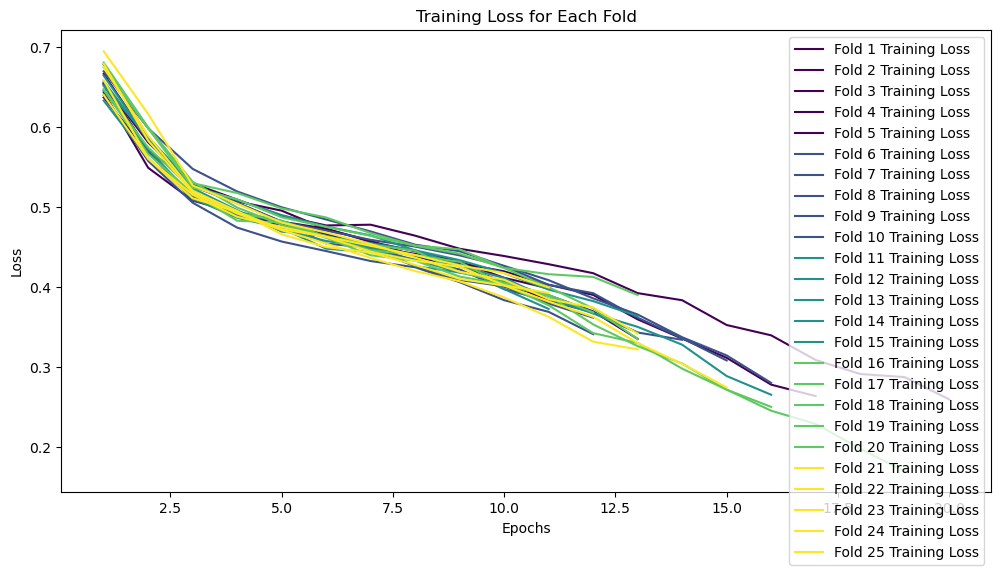

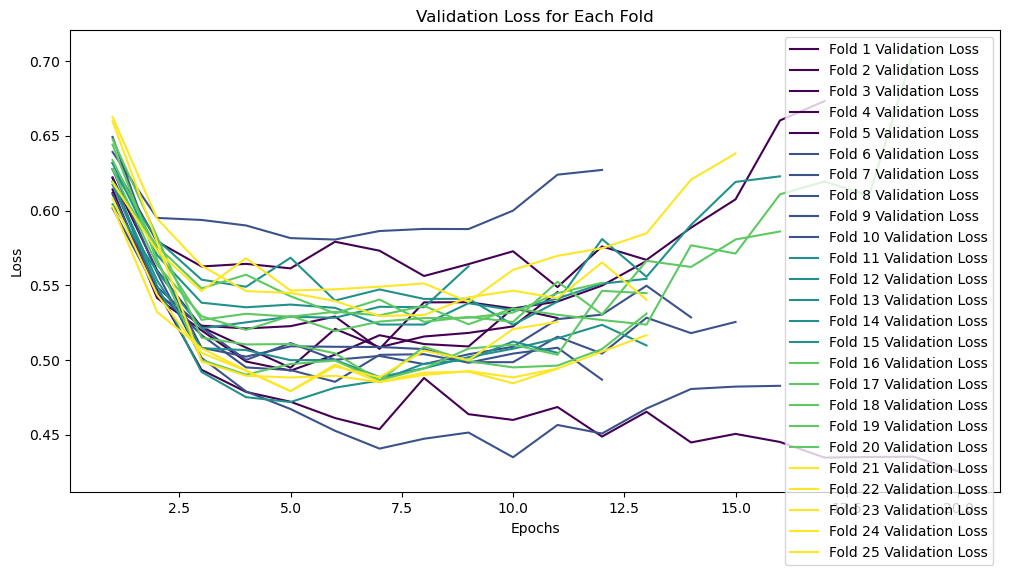

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()